In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nltk
import re, string
#from textblob import TextBlob
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_val_score

In [88]:
df_train = pd.read_csv("C:\\Users\\lavle\\Desktop\\DCU\\Semester_2\\Machine_Learning\\Project\\train_data\\train.csv")
df_test = pd.read_csv("C:\\Users\\lavle\\Desktop\\DCU\\Semester_2\\Machine_Learning\\Project\\test_data\\test.csv")
df_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


Data Understanding

In [89]:
lens = df_train.comment_text.str.len()
lens.mean(), lens.std(), lens.max(), lens.min()

(394.7120842759649, 591.9907293798376, 5895, 6)

In [90]:
df_test.shape

(153164, 2)

In [91]:
len(df_train)

159571

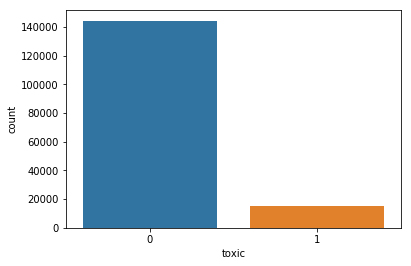

In [92]:
sns.countplot(df_train['toxic'])

We have a class imbalance as shown below:

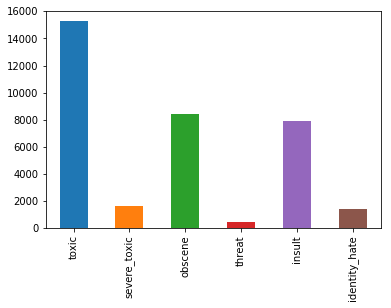

In [93]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
df_train[label_cols].sum().plot.bar()

In [94]:
text1 = df_train.comment_text[2124]
text1

"The only thing you are persistant at you ugly bastard is fucking the TROLL'''"

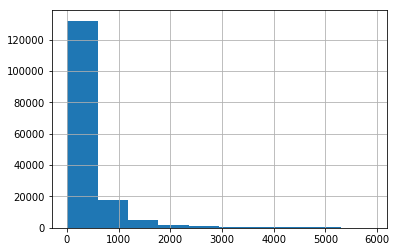

In [95]:
#Most of the comments are within the length of 500 words
plt.hist(lens)
plt.grid()

plt.show()

Checking the number of toxic comments we have in training dataset

In [96]:
df_train['category'] = df_train[label_cols].max(axis=1)

Just to have a look at the toxic comments in the training dataset

In [97]:
count_toxic = df_train['category'].sum()#df_train[df_train['category'] != 0].count     #.sum
count_toxic

16225

In [98]:
percentage_toxic = float(count_toxic)/len(df_train)
print(percentage_toxic*100)

10.1678876488


So, we have total 16225 toxic comments in the training dataset out of a total of 159571 comments.
which is only 10% of total comments.

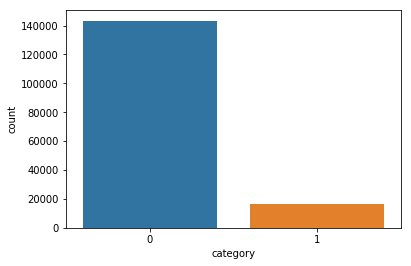

In [99]:
sns.countplot(df_train['category'])

In [100]:
df_train.columns

Index([u'id', u'comment_text', u'toxic', u'severe_toxic', u'obscene',
       u'threat', u'insult', u'identity_hate', u'category'],
      dtype='object')

In [101]:
df_train['comment_text'].notna().sum()

159571

So, we don't have any null values in the dataset.

In [102]:
df_train.isnull().any()

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
category         False
dtype: bool

Model 1: Initital Classification - Logistic Regression

In [103]:
#Removing unecessary punctutation from the comments
re_tok = re.compile("([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])")
def tokenize(s): 
    return re_tok.sub(r' \1 ', s).split()

In [116]:
n = df_train.shape[0]
# sublinear_tf = True -> To use a logarithmic form of Frequency
# min_df = 3          -> minimum numbers of documents a word must be present in to be kept
# norm = l2           -> to ensure all our feature vectors have a euclidian norm of 1
# stop_words = 'english' -> As we're dealing with English comments, removing the stopwords for model to be efficient
vec = TfidfVectorizer( ngram_range=(1,2),       tokenizer=tokenize,
                       min_df=5,                max_df=0.9, 
                       strip_accents='unicode', use_idf=1,
                       smooth_idf=1,            sublinear_tf=1, 
                       norm = 'l2',             stop_words='english' )

Transform training and test data into feature vectors

In [117]:
train_features = vec.fit_transform(df_train['comment_text'])
test_features = vec.transform(df_test['comment_text'])

In [118]:
train_features.shape, test_features.shape

((159571, 48757), (153164, 48757))

In [119]:
model = LogisticRegression(C=4, dual=True)

Fitting the model and predicting the probability

In [30]:
predictions_df = np.zeros((len(df_test), len(label_cols)))
for i, col in enumerate(label_cols):
    print("fit: ", col)
    classifier = model.fit(train_features, df_train[col].values)
    predictions_df[:,i] = classifier.predict_proba(test_features)[:,1]
    #pred_df = pd.DataFrame(predictions)
    print(predictions_df.shape)

('fit: ', 'toxic')
(153164L, 6L)
('fit: ', 'severe_toxic')
(153164L, 6L)
('fit: ', 'obscene')
(153164L, 6L)
('fit: ', 'threat')
(153164L, 6L)
('fit: ', 'insult')
(153164L, 6L)
('fit: ', 'identity_hate')
(153164L, 6L)


Accuracy using Cross Validation Score

In [121]:
for col in label_cols:
    accuracy = cross_val_score(model, train_features, df_train[col].values, scoring='accuracy', cv=5)
    print(col, ": ", accuracy.mean())

('toxic', ': ', 0.94185033445413846)
('severe_toxic', ': ', 0.99020498837688786)
('obscene', ': ', 0.97210019197915076)
('threat', ': ', 0.9972551404210096)
('insult', ': ', 0.9664851544391253)
('identity_hate', ': ', 0.99180302153687738)


Let's try to predict the probability of a random text using LogisticRegression

In [120]:
pred_text_a = np.zeros((1, len(label_cols)))
text_feat = vec.transform(['happy happy happy happy happy happy happy happy happy'])#Go fuck yourself dickhead nigger'])
for i, col in enumerate(label_cols):
    print("fit: ", col)
    classifier = model.fit(train_features, df_train[col].values)
    pred_text_a[:,i] = classifier.predict_proba(text_feat)[:,1]
print label_cols
print(pred_text_a)

('fit: ', 'toxic')
('fit: ', 'severe_toxic')
('fit: ', 'obscene')
('fit: ', 'threat')
('fit: ', 'insult')
('fit: ', 'identity_hate')
['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
[[ 0.02188504  0.00024522  0.0085725   0.0002749   0.01268153  0.00135546]]


Model 1: Initial Classification - LinearSVC()

In [123]:
model_svc = LinearSVC()

In [124]:
for col in label_cols:
    accuracy_svc = cross_val_score(model_svc, train_features, df_train[col].values, scoring='accuracy', cv=5)
    print(col, ": ", accuracy_svc.mean())

('toxic', ': ', 0.94122365809450825)
('severe_toxic', ': ', 0.9902676564055497)
('obscene', ': ', 0.97194978894590922)
('threat', ': ', 0.99726767410529837)
('insult', ': ', 0.96622821155486149)
('identity_hate', ': ', 0.99180928857537576)
